In [1]:
import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.utils.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

Using diffeqsolve-based neural simulation (original)


In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["ytick.minor.size"] = 1.0
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["ytick.minor.width"] = 0.18

plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC data

In [4]:
wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20250813_DNtoMN_unsorted_withModules.csv",index_col=0)
wTable

,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
0,10000,DNp01,descending neuron,lt,NaN,38743961712,acetylcholine,0.514212,0.514212,0.170715,0.217547,NaN,NaN,NaN
1,10002,DNp01,descending neuron,lt,NaN,39414880927,acetylcholine,0.459629,0.459629,0.143481,0.256230,NaN,NaN,NaN
2,10010,IN07B001,intrinsic neuron,BI,07B,13014023633,acetylcholine,0.939965,0.940393,0.012989,0.042836,LHS,NaN,NaN
3,10012,DNp18,descending neuron,xn,NaN,11298761013,acetylcholine,0.855257,0.855257,0.041924,0.097816,NaN,NaN,NaN
4,10016,AN19B001,ascending neuron,BA,19B,11932392103,acetylcholine,0.919254,0.920013,0.016480,0.059285,LHS,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,53202877530,DNxl071,descending neuron,xl,NaN,204733269,acetylcholine,0.659697,0.659697,0.259675,0.061893,NaN,NaN,NaN
4600,53581075416,DNxn108,descending neuron,xn,NaN,123533994,acetylcholine,0.496949,0.496949,0.155641,0.293903,NaN,NaN,NaN
4601,53588309438,DNxn104,descending neuron,xn,NaN,103854550,acetylcholine,0.956760,0.956760,0.007562,0.031505,NaN,NaN,NaN
4602,53595462076,DNxn137,descending neuron,xn,NaN,151068232,acetylcholine,0.965196,0.965196,0.004080,0.029553,NaN,NaN,NaN


In [14]:
dns = wTable.loc[wTable["class"]=="descending neuron"]
mns = wTable.loc[wTable["class"]=="motor neuron"]
excIns = wTable.loc[(~wTable["class"].isin(["descending neuron","motor neuron"])&(wTable["predictedNt"]=="acetylcholine"))]
inhIns = wTable.loc[(~wTable["class"].isin(["descending neuron","motor neuron"])&(~(wTable["predictedNt"]=="acetylcholine")))]

In [15]:
print("descending: "+str(len(dns)))
print("excitatory premotor: "+str(len(excIns)))
print("inhibitory premotor: "+str(len(inhIns)))
print("motor: "+str(len(mns)))

descending: 1318
excitatory premotor: 1484
inhibitory premotor: 1658
motor: 144


In [16]:
len(dns)+len(excIns)+len(inhIns)+len(mns)

4604

## DN screen

In [3]:
simType = "DN_Screen"
simPath = simType+"/hyak/run_id=28340113"
folder = dataPath + simPath

params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1],index_col=0)
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
neuronParams = h5py.File(folder+"/ckpt/neuron_params.h5","r")

inputs = neuronParams["input_currents"]
nDns = inputs.shape[0]
nReps = inputs.shape[1]

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
# scores = np.zeros((nDns,nReps))
# nActive = np.zeros((nDns,nReps))
# # nMnsActive = np.zeros((nDns,nReps))
# dnIdxList = []

# nrnNo = 0
# for batch in range(59):
#     Rs_batch = sparse.load_npz(folder+f"/ckpt/checkpoints/results_final/Final_batch_Rs_{batch}.npz").todense()
#     for nrn in range(int(len(Rs_batch)/nReps)):
#         dnIdxList += np.where(inputs[nrnNo].sum(0)>0)[0].tolist()
#         for rep in range(nReps):
#             R = Rs_batch[nrn*nReps+rep]
#             activeMask = np.max(R,1)>0.01
#             nActive[nrnNo,rep] = np.sum(activeMask)
#             # activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#             # nMnsActive[nrnNo,rep] = np.sum(activeMnsMask)
#             activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#             score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
#             scores[nrnNo,rep] = score
#         nrnNo += 1

In [5]:
# scoreSummary = pd.DataFrame(scores,index=dnIdxList)
# activitySummary = pd.DataFrame(nActive,index=dnIdxList)
#
# figFolder = "../figures/"
# figFolder += "-".join(str.split(simPath,"/"))

# if not os.path.exists(figFolder):
#     os.makedirs(figFolder)
# scoreSummary.to_csv(figFolder+"/scoreSummary.csv")
# activitySummary.to_csv(figFolder+"/activitySummary.csv")

In [8]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

scores = pd.read_csv(figFolder+"/scoreSummary.csv",index_col=0)
nActive = pd.read_csv(figFolder+"/activitySummary.csv",index_col=0)

dnIdxList = []
for i in range(len(scores)):
    dnIdxList += np.where(inputs[i].sum(0)>0)[0].tolist()

In [9]:
usableScores = scores.copy()
usableScores[nActive<5]=np.nan
usableScores[nActive>500]=np.nan
usableScoreSummary = pd.DataFrame(usableScores,index=dnIdxList)
usableScoreSummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4600,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
usableScoreSummary["mean"] = usableScoreSummary.mean(1,skipna=True)
usableScoreSummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109138
7,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
20,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.000000
4600,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002302
4601,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
usableScoreSummary.insert(0,"bodyId",usableScoreSummary.index.map(dict(zip(wTable.index,wTable["bodyId"]))))
usableScoreSummary

,bodyId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
0,10000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,10002,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,10012,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109138
7,10021,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
20,10061,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,51939777929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,53202877530,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.000000
4600,53581075416,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002302
4601,53588309438,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
usableScoreSummary.sort_values("mean",ascending=False)

,bodyId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
132,10339,0.998818,0.989875,0.995873,1.000211,0.998084,0.973427,0.973243,0.996819,1.002357,0.997735,1.002506,0.889716,0.997364,0.999523,0.931903,0.987328,0.983424
31,10093,0.936705,0.891175,0.997490,1.000043,0.996282,1.000092,1.001227,0.995574,0.931632,0.995963,0.950768,0.999098,0.998793,0.996960,0.998782,0.967047,0.978602
1211,14061,0.993952,NaN,0.997660,0.968734,NaN,0.985149,0.963076,0.991625,0.994045,NaN,NaN,0.706906,0.995877,0.925064,0.957911,0.983032,0.955253
3602,30919,0.918934,0.843272,0.944500,0.756300,0.834266,0.885887,0.778689,0.998175,0.999247,0.908585,0.975560,0.775671,0.990972,0.944558,0.960339,0.974609,0.905598
2048,18279,0.864892,0.995580,0.851715,0.930740,0.891598,0.845125,0.884371,0.847077,0.847809,0.971836,0.389601,0.972363,0.956787,0.899060,0.967105,0.737755,0.865838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,153153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4473,163639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,163893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4512,166522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
sum(usableScoreSummary["mean"].notna())

749

In [15]:
sum(usableScoreSummary["mean"].isna())

184

In [16]:
184/933

0.19721329046087888

In [18]:
sum(usableScoreSummary["mean"]==0)

455

In [20]:
455/749

0.6074766355140186

In [21]:
sum(usableScoreSummary["mean"]>=0.2)

88

In [22]:
sum(usableScoreSummary["mean"]>=0.5)

37

In [23]:
37/749

0.049399198931909215

In [24]:
37/933

0.03965702036441586

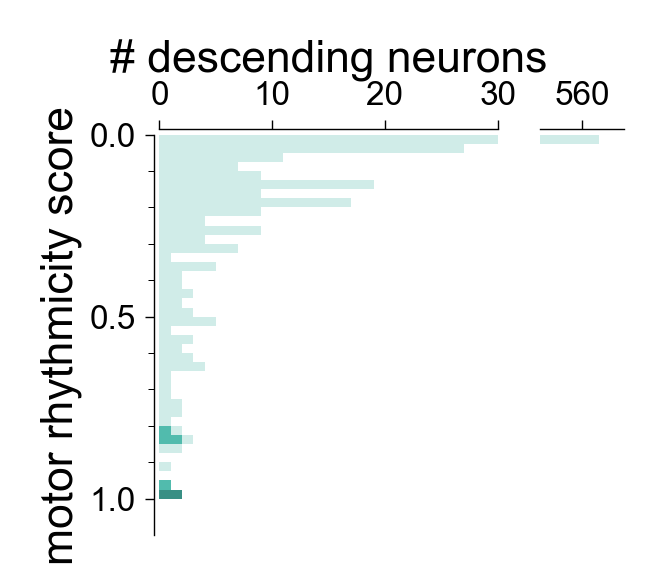

In [157]:
fig,ax = plt.subplots(1,2,width_ratios=[4,1])#,sharex=True)

sns.histplot(y=usableScoreSummary["mean"].dropna(),bins=np.arange(0,1.1,0.025),color="#d0ece8ff",edgecolor="None",ax=ax[0],alpha=1,zorder=-1)
sns.histplot(y=usableScoreSummary.loc[usableScoreSummary.index.isin(wTable.loc[wTable["type"]=="DNb08"].index),"mean"],
             bins=np.arange(0,1.1,0.025),color="#51bbad",edgecolor="None",ax=ax[0],alpha=1,zorder=1)
sns.histplot(y=usableScoreSummary.loc[usableScoreSummary.index.isin(wTable.loc[wTable["type"]=="DNg100"].index),"mean"],
             bins=np.arange(0,1.1,0.025),color="#388f84ff",edgecolor="None",ax=ax[0],alpha=1,zorder=1)
ax[0].set_xlabel("# descending neurons")
ax[0].xaxis.set_label_position("top")
ax[0].set_ylabel("motor rhythmicity score")
ax[0].set_xticks(np.arange(0,31,10))
ax[0].set_yticks(np.arange(0,1.1,0.5))
ax[0].set_yticks(np.arange(0,1.1,0.1),minor=True)
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0,30])
ax[0].invert_yaxis()

sns.histplot(y=usableScoreSummary["mean"].dropna(),bins=np.arange(0,1.1,0.025),color="#d0ece8ff",edgecolor="None",ax=ax[1],alpha=1)
ax[1].invert_yaxis()
ax[1].set_xlabel("")
ax[1].set_xticks([560,570])
ax[1].set_xlim([555,565])
ax[1].set_ylim([1.1,0])
ax[1].set_yticks([])
ax[1].set_ylabel("")

sns.despine(offset=1,ax=ax[0],top=False,bottom=True)
sns.despine(offset=1,ax=ax[1],top=False,bottom=True,left=True)
ax[0].xaxis.tick_top()
ax[1].xaxis.tick_top()

fig.set_dpi(400)

fig.set_figheight(1.3)
fig.set_figwidth(1.5)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/dnScoresHist.svg",transparent=True)
plt.show()

### supplementary tables

In [3]:
simType = "DN_Screen"
simPath = simType+"/hyak/run_id=28340113"
folder = dataPath + simPath

params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1],index_col=0)
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
neuronParams = h5py.File(folder+"/ckpt/neuron_params.h5","r")

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

scores = pd.read_csv(figFolder+"/scoreSummary.csv",index_col=0)
nActive = pd.read_csv(figFolder+"/activitySummary.csv",index_col=0)

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
inputs = neuronParams["input_currents"]
dnIdxList = []

for i in range(len(scores)):
    dnIdxList += np.where(inputs[i].sum(0)>0)[0].tolist()

In [5]:
usableScores = scores.copy()
usableScores[nActive<5]=np.nan
usableScores[nActive>500]=np.nan
usableScoreSummary = pd.DataFrame(usableScores,index=dnIdxList)
usableScoreSummary["mean"] = usableScoreSummary.mean(1,skipna=True)
usableScoreSummary.insert(0,"bodyId",usableScoreSummary.index.map(dict(zip(wTable.index,wTable["bodyId"]))))
usableScoreSummary.insert(1,"type",usableScoreSummary.index.map(dict(zip(wTable.index,wTable["type"]))))
usableScoreSummary = usableScoreSummary.sort_values("mean",ascending=False)

In [6]:
## Supplemental table 1
print(usableScoreSummary[["bodyId","type","mean"]].iloc[:37].to_latex(index=False))

\begin{tabular}{rlr}
\toprule
bodyId & type & mean \\
\midrule
10339 & DNg100 & 0.983424 \\
10093 & DNg100 & 0.978602 \\
14061 & DNb08 & 0.955253 \\
30919 & DNg12 & 0.905598 \\
18279 & DNp41 & 0.865838 \\
16683 & DNxl091 & 0.860995 \\
18153 & DNp41 & 0.847139 \\
14966 & DNb08 & 0.841571 \\
13892 & DNb08 & 0.839170 \\
32815 & DNg12 & 0.813234 \\
14680 & DNb08 & 0.801999 \\
25931 & DNa07 & 0.786021 \\
12221 & DNxl121 & 0.766589 \\
44321 & DNit011 & 0.764497 \\
23461 & DNfl031 & 0.735547 \\
17031 & DNxl092 & 0.731611 \\
15841 & DNp71 & 0.714360 \\
19821 & DNg54 & 0.687533 \\
32742 & DNg12 & 0.668965 \\
38587 & DNg12 & 0.647725 \\
37139 & DNit013 & 0.646784 \\
30130 & DNxn167 & 0.636139 \\
11164 & DNa13 & 0.625670 \\
26047 & DNg09 & 0.624473 \\
11145 & DNa13 & 0.620487 \\
16264 & DNxn159 & 0.603845 \\
10291 & DNxl134 & 0.586567 \\
25645 & DNut054 & 0.584007 \\
23962 & DNxn127 & 0.567792 \\
10896 & DNxl133 & 0.566917 \\
11981 & DNp43 & 0.551802 \\
22194 & DNxn171 & 0.546201 \\
27523 & DNfl0

In [48]:
## Supplemental table 2
typesOfInterest = ["DNg100","DNb08","DNg97","MDN","DNa02","DNp09","DNg62","DNg12","DNa11","DNg08"] #DNg97 = oDN1, DNg62 = aDN1
print(usableScoreSummary.loc[usableScoreSummary["type"].isin(typesOfInterest),["bodyId","type","mean"]].to_latex(index=False))

\begin{tabular}{rlr}
\toprule
bodyId & type & mean \\
\midrule
10339 & DNg100 & 0.983424 \\
10093 & DNg100 & 0.978602 \\
14061 & DNb08 & 0.955253 \\
30919 & DNg12 & 0.905598 \\
14966 & DNb08 & 0.841571 \\
13892 & DNb08 & 0.839170 \\
32815 & DNg12 & 0.813234 \\
14680 & DNb08 & 0.801999 \\
32742 & DNg12 & 0.668965 \\
38587 & DNg12 & 0.647725 \\
14419 & MDN & 0.429656 \\
35473 & DNg12 & 0.424952 \\
18107 & DNa11 & 0.399258 \\
13809 & MDN & 0.321310 \\
11070 & DNg97 & 0.257257 \\
35413 & DNg12 & 0.247020 \\
34862 & DNg12 & 0.219746 \\
31078 & DNg12 & 0.184643 \\
31613 & DNg12 & 0.137115 \\
40338 & DNg12 & 0.093108 \\
10656 & DNg97 & 0.040061 \\
31361 & DNg12 & 0.035059 \\
31742 & DNg12 & 0.021896 \\
10126 & DNa02 & 0.015600 \\
32424 & DNg12 & 0.014636 \\
152849 & DNg62 & 0.012459 \\
24753 & DNg62 & 0.009698 \\
25606 & DNg08 & 0.002548 \\
31635 & DNg12 & 0.001649 \\
29706 & DNg12 & 0.000000 \\
27728 & DNg12 & 0.000000 \\
10118 & DNa02 & 0.000000 \\
34253 & DNg12 & 0.000000 \\
30271 & DNg12 

In [49]:
print(usableScoreSummary.loc[usableScoreSummary["type"].isin(typesOfInterest),["bodyId","type","mean"]].sort_values(["type","mean"]).to_latex(index=False))

\begin{tabular}{rlr}
\toprule
bodyId & type & mean \\
\midrule
10118 & DNa02 & 0.000000 \\
10126 & DNa02 & 0.015600 \\
17155 & DNa11 & 0.000000 \\
18107 & DNa11 & 0.399258 \\
14680 & DNb08 & 0.801999 \\
13892 & DNb08 & 0.839170 \\
14966 & DNb08 & 0.841571 \\
14061 & DNb08 & 0.955253 \\
24458 & DNg08 & 0.000000 \\
23518 & DNg08 & 0.000000 \\
18953 & DNg08 & 0.000000 \\
25606 & DNg08 & 0.002548 \\
10093 & DNg100 & 0.978602 \\
10339 & DNg100 & 0.983424 \\
29706 & DNg12 & 0.000000 \\
27728 & DNg12 & 0.000000 \\
34253 & DNg12 & 0.000000 \\
30271 & DNg12 & 0.000000 \\
28478 & DNg12 & 0.000000 \\
22875 & DNg12 & 0.000000 \\
24858 & DNg12 & 0.000000 \\
31635 & DNg12 & 0.001649 \\
32424 & DNg12 & 0.014636 \\
31742 & DNg12 & 0.021896 \\
31361 & DNg12 & 0.035059 \\
40338 & DNg12 & 0.093108 \\
31613 & DNg12 & 0.137115 \\
31078 & DNg12 & 0.184643 \\
34862 & DNg12 & 0.219746 \\
35413 & DNg12 & 0.247020 \\
35473 & DNg12 & 0.424952 \\
38587 & DNg12 & 0.647725 \\
32742 & DNg12 & 0.668965 \\
32815 & DNg